In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.interpolate import griddata
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

# %config InlineBackend.figure_format = 'retina'
# plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

# Typo - page 247, when specifying priors for alpha, they should be a ~ normal(1,0.1)
# Typo - page 250, "despite IT'S (its) predictive superiority"
# Typo - page 257, "in other cases, you may want more or LESS (fewer)" though my wife would punch me for this one
# Typo - questions mislabeled
# Typo - page 265, figure link broken

In [10]:
# R code 8.1

d = pd.read_csv('Data/rugged.csv', sep=';', header=0)
d['log_gdp']=np.log(d['rgdppc_2000'])
dd = d.drop(d[d['rgdppc_2000'].isnull()].index)
dd['log_gdp_std']=dd['log_gdp']/dd['log_gdp'].mean()
dd['rugged_std']=dd['rugged']/dd['rugged'].max()
d_A1 = dd[dd['cont_africa']==1]
d_A0 = dd[dd['cont_africa']==0]

In [11]:
# R code 8.2

with pm.Model() as m_8_1:
    alpha = pm.Normal('alpha', mu=1, sd=1) 
    beta = pm.Normal('beta', mu=0, sd=1) 
    mu = pm.Deterministic('mu', alpha + beta * (d_A1.rugged_std - dd['rugged_std'].mean()))
    sigma = pm.Exponential('sigma', 1)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=d_A1.log_gdp_std)
    trace_8_1= pm.sample(5000, tune=1000, chains=1) 
    prior_8_1 = pm.sample_prior_predictive(samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1112.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


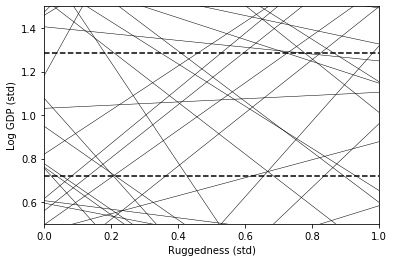

In [12]:
# R code 8.3 (note: prior stuff was extracted in 8.2)

xvals = np.linspace(0,1,1000)
k=0
while k<50:
    plt.plot(xvals, prior_8_1['alpha'][k] + prior_8_1['beta'][k]*xvals, linewidth=0.5, color='k')

    k+=1
plt.xlim([0,1])
plt.ylim([0.5,1.5])
plt.plot((0,1), (dd['log_gdp_std'].min(),dd['log_gdp_std'].min()), 'k--')
plt.plot((0,1), (dd['log_gdp_std'].max(), dd['log_gdp_std'].max()), 'k--')
plt.xlabel("Ruggedness (std)")
plt.ylabel("Log GDP (std)");

# These priors are terrible. Alpha is too broad. So is beta. 

In [13]:
# R code 8.5

with pm.Model() as m_8_1:
    alpha = pm.Normal('alpha', mu=1, sd=0.1) 
    beta = pm.Normal('beta', mu=0, sd=0.3) 
    mu = pm.Deterministic('mu', alpha + beta * (d_A1.rugged_std - dd['rugged_std'].mean()))
    sigma = pm.Exponential('sigma', 1)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=d_A1.log_gdp_std)
    trace_8_1= pm.sample(5000, tune=1000, chains=1) 
    prior_8_1 = pm.sample_prior_predictive(samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1264.59it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


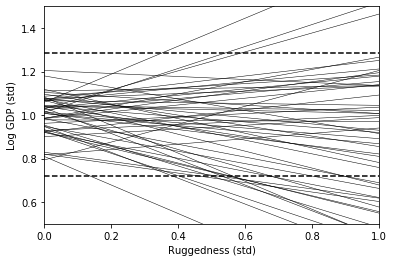

In [14]:
# Right side of figure 8.3

xvals = np.linspace(0,1,1000)
k=0
while k<50:
    plt.plot(xvals, prior_8_1['alpha'][k] + prior_8_1['beta'][k]*xvals, linewidth=0.5, color='k')

    k+=1
plt.xlim([0,1])
plt.ylim([0.5,1.5])
plt.plot((0,1), (dd['log_gdp_std'].min(),dd['log_gdp_std'].min()), 'k--')
plt.plot((0,1), (dd['log_gdp_std'].max(), dd['log_gdp_std'].max()), 'k--')
plt.xlabel("Ruggedness (std)")
plt.ylabel("Log GDP (std)");

# These priors are much more reasonable.

In [15]:
# R code 8.6
# Non-African nations

with pm.Model() as m_8_2:
    alpha = pm.Normal('alpha', mu=1, sd=0.1) 
    beta = pm.Normal('beta', mu=0, sd=0.3) 
    mu = pm.Deterministic('mu', alpha + beta * (d_A0.rugged_std - dd['rugged_std'].mean()))
    sigma = pm.Exponential('sigma', 1)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=d_A0.log_gdp_std)
    trace_8_2= pm.sample(5000, tune=1000, chains=1) 
    prior_8_2 = pm.sample_prior_predictive(samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1196.19it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [16]:
# African nations
varnames = ['alpha', 'beta', 'sigma']
pm.summary(trace_8_1, var_names = varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,0.89,0.02,0.0,0.86,0.91
beta,0.13,0.07,0.0,0.01,0.24
sigma,0.11,0.01,0.0,0.09,0.13


In [17]:
# Non-African nations
pm.summary(trace_8_2, var_names = varnames, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha,1.05,0.01,0.0,1.04,1.07
beta,-0.14,0.06,0.0,-0.23,-0.05
sigma,0.11,0.01,0.0,0.10,0.13


In [18]:
# R code 8.7
# But we want to include all countries in one model. First, the simple model.

with pm.Model() as m_8_3:
    alpha = pm.Normal('alpha', mu=1, sd=0.1) 
    beta = pm.Normal('beta', mu=0, sd=0.3) 
    mu = pm.Deterministic('mu', alpha + beta * (dd.rugged_std - dd['rugged_std'].mean()))
    sigma = pm.Exponential('sigma', 1)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=dd.log_gdp_std)
    trace_8_3= pm.sample(5000, tune=1000, chains=1) 
    prior_8_3 = pm.sample_prior_predictive(samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:04<00:00, 1344.35it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
# R code 8.8

cid = pd.Categorical(dd['cont_africa'])
dd['cid']=cid.codes

In [20]:
# R code 8.9

with pm.Model() as m_8_4:
    alpha = pm.Normal('alpha', mu=1, sd=0.1, shape=2) 
    beta = pm.Normal('beta', mu=0, sd=0.3) 
    mu = alpha[cid] + beta * (dd.rugged_std - dd['rugged_std'].mean())
    sigma = pm.Exponential('sigma', 1)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=dd.log_gdp_std)
    trace_8_4= pm.sample(5000, tune=1000, chains=1)

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
1

In [13]:
# R code 8.10

m_8_3.name = 'not distinguishing A/~A'
m_8_4.name = 'different alpha for A/~A'
comp_WAIC = pm.compare({m_8_3: trace_8_3, m_8_4: trace_8_4})
comp_WAIC

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`,

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
different alpha for A/~A,-252.28,4.14,0,0.97,14.79,0,1
not distinguishing A/~A,-188.81,2.6,63.47,0.03,12.92,14.6,0


In [14]:
# R code 8.11
# a[0] is for non-African nations.

pm.summary(trace_8_4, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha__0,1.05,0.01,0.0,1.03,1.07
alpha__1,0.88,0.02,0.0,0.86,0.91
beta,-0.05,0.05,0.0,-0.12,0.03
sigma,0.11,0.01,0.0,0.10,0.12


In [15]:
trace_8_4['alpha'].shape

(5000, 2)

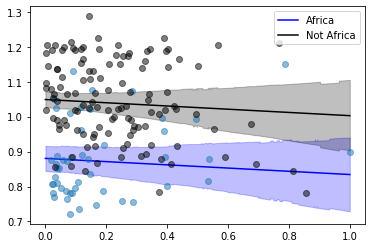

In [16]:
# R code 8.12, generating figure 8.4

x=np.linspace(0, 1, 1000)

mu_not_africa = trace_8_4['alpha'][:,0] + trace_8_4['beta'] * x[:,None]
mu_africa = trace_8_4['alpha'][:,1] + trace_8_4['beta'] * x[:,None]
plt.plot(x, mu_africa.mean(1), 'b', label='Africa')
plt.plot(x, mu_not_africa.mean(1), 'k', label = 'Not Africa')
mu_africa_hpd = pm.hpd(mu_africa.T, alpha = 0.03)
mu_not_africa_hpd = pm.hpd(mu_not_africa.T, alpha = 0.03)
plt.fill_between(x, mu_africa_hpd[:,0], mu_africa_hpd[:,1], color='b', alpha=0.25)
plt.fill_between(x, mu_not_africa_hpd[:,0], mu_not_africa_hpd[:,1], color='k', alpha=0.25)

plt.plot(d_A1['rugged_std'], d_A1['log_gdp_std'], 'o', alpha = 0.5)
plt.plot(d_A0['rugged_std'], d_A0['log_gdp_std'], 'ok', alpha = 0.5)
plt.legend();

In [17]:
# R code 8.13
with pm.Model() as m_8_5:
    alpha = pm.Normal('alpha', mu=1, sd=0.1, shape=2) 
    beta = pm.Normal('beta', mu=0, sd=0.3, shape=2) 
    mu = alpha[cid] + beta[cid]* (dd.rugged_std - dd['rugged_std'].mean())
    sigma = pm.Exponential('sigma', 1)
    log_gdp_std = pm.Normal('log_gdp_std', mu=mu, sd=sigma, observed=dd.log_gdp_std)
    trace_8_5= pm.sample(5000, tune=1000, chains=1)

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, beta, alpha]
1

In [18]:
# R code 8.14
# a[0] is for non-African nations.

pm.summary(trace_8_5, alpha = 0.11).round(2)

,mean,sd,mc_error,hpd_5.5,hpd_94.5
alpha__0,1.05,0.01,0.0,1.03,1.07
alpha__1,0.89,0.02,0.0,0.86,0.91
beta__0,-0.14,0.06,0.0,-0.23,-0.05
beta__1,0.13,0.08,0.0,0.01,0.26
sigma,0.11,0.01,0.0,0.10,0.12


In [19]:
# R code 8.15
m_8_5.name = 'different alpha and beta for A/~A'
comp_WAIC = pm.compare({m_8_3: trace_8_3, m_8_4: trace_8_4, m_8_5: trace_8_5})
comp_WAIC

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indication of
        WAIC starting to fail see http://arxiv.org/abs/1507.04544 for details
        
  """)
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.s

,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
different alpha and beta for A/~A,-259.13,5.02,0,0.87,14.61,0,1
different alpha for A/~A,-252.28,4.14,6.85,0.13,14.79,6.44,1
not distinguishing A/~A,-188.81,2.6,70.32,0,12.92,14.88,0


In [20]:
# R code 8.16

waic_m_8_5 = pm.waic(trace_8_5, model=m_8_5, pointwise=True)

# This part of the text is unfinished - there is no explanation what to do with the pointwise WAIC values.

C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:168: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  return np.stack(logp)
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\theano\tensor\subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
C:\Users\mviotti\AppData\Local\Continuum\anaconda3\envs\stats\lib\site-packages\pymc3\stats.py:219: UserWarning: For one or more samples the posterior variance of the
        log predictive densities exceeds 0.4. This could be indicat

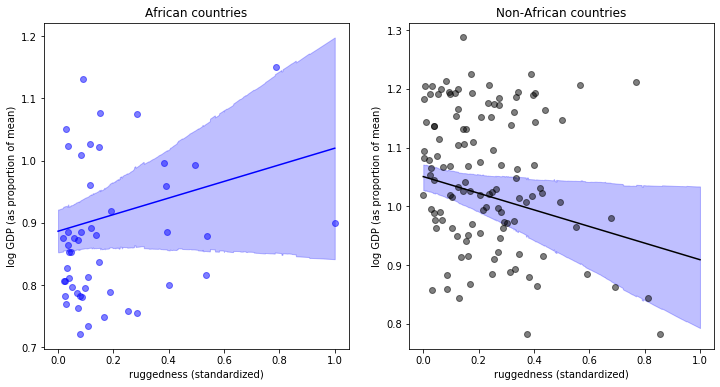

In [21]:
# R code 8.17

x=np.linspace(0, 1, 1000)
f = plt.figure(figsize=(12,6))

mu_not_africa = trace_8_5['alpha'][:,0] + trace_8_5['beta'][:,0] * x[:,None]
mu_africa = trace_8_5['alpha'][:,1] + trace_8_5['beta'][:,1] * x[:,None]
mu_africa_hpd = pm.hpd(mu_africa.T, alpha = 0.03)
mu_not_africa_hpd = pm.hpd(mu_not_africa.T, alpha = 0.03)

ax1=f.add_subplot(121)
ax1.plot(d_A1['rugged_std'], d_A1['log_gdp_std'], 'ob', alpha = 0.5)
ax1.plot(x, mu_africa.mean(1), 'b')
ax1.fill_between(x, mu_africa_hpd[:,0], mu_africa_hpd[:,1], color='b', alpha=0.25)
ax1.set_xlabel("ruggedness (standardized)")
ax1.set_ylabel("log GDP (as proportion of mean)")
ax1.title.set_text('African countries')

ax2=f.add_subplot(122)
ax2.plot(d_A0['rugged_std'], d_A0['log_gdp_std'], 'ok', alpha = 0.5)
ax2.plot(x, mu_not_africa.mean(1), 'k')
ax2.fill_between(x, mu_not_africa_hpd[:,0], mu_not_africa_hpd[:,1], color='b', alpha=0.25)
ax2.set_xlabel("ruggedness (standardized)")
ax2.set_ylabel("log GDP (as proportion of mean)")
ax2.title.set_text('Non-African countries');

In [22]:
# R code 8.18 - skipping for now

In [2]:
# R code 8.19

d = pd.read_csv('Data/tulips.csv', sep=';', header=0)

In [3]:
# R code 8.20
d['blooms_std']= d.blooms/d.blooms.max()
d['water_cent']=d.water - d.water.mean()
d['shade_cent']=d.shade -d.shade.mean()

In [25]:
# R code 8.21
x = stats.norm.rvs(loc=0.5, scale=1, size = 1000)
(x[x>1].shape[0] + x[x<0].shape[0])/x.shape[0]

# Over 60% outside of the reasonable values - that's crazy.

0.622

In [26]:
# R code 8.22
x = stats.norm.rvs(loc=0.5, scale=0.25, size = 1000)
(x[x>1].shape[0] + x[x<0].shape[0])/x.shape[0]

# 4% outside of reasonable values - makes more sense.

0.043

In [4]:
# R code 8.23

with pm.Model() as m_8_6:
    a = pm.Normal('a', mu=0.5, sd=0.25) 
    b_water = pm.Normal('b_water', mu=0, sd=0.25) 
    b_shade = pm.Normal('b_shade', mu=0, sd=0.25) 
    mu = a + b_water* (d.water_cent) + b_shade*d.shade_cent
    sigma = pm.Exponential('sigma', 1)
    blooms_std = pm.Normal('blooms_std', mu=mu, sd=sigma, observed=d.blooms_std)
    trace_8_6= pm.sample(5000, tune=1000, chains=1)
    prior_8_6 = pm.sample_prior_predictive(samples=1000)
    #start = {'a':np.mean(d.blooms), 'b_water':0, 'b_shade':0, 'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_shade, b_water, a]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1193.15it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [8]:
# R code 8.24

with pm.Model() as m_8_7:
    a = pm.Normal('a', mu=0.5, sd=0.25) 
    b_water = pm.Normal('b_water', mu=0, sd=0.25) 
    b_shade = pm.Normal('b_shade', mu=0, sd=0.25)
    b_water_shade = pm.Normal('b_water_shade', mu=0, sd=0.25)
    mu = (a + b_water * (d.water_cent) + b_shade * d.shade_cent 
          + b_water_shade * d.water_cent * d.shade_cent)
    sigma = pm.Exponential('sigma', 1)
    blooms_std = pm.Normal('blooms_std', mu=mu, sd=sigma, observed=d.blooms_std)
    trace_8_7= pm.sample(5000, tune=1000, chains=1)
    prior_8_7 = pm.sample_prior_predictive(samples=1000)
    #start = {'a':np.mean(d.blooms), 'b_water':0, 'b_shade':0, 'b_water_shade':0,'sigma':np.std(d.blooms)}

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_water_shade, b_shade, b_water, a]
100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:05<00:00, 1115.41it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


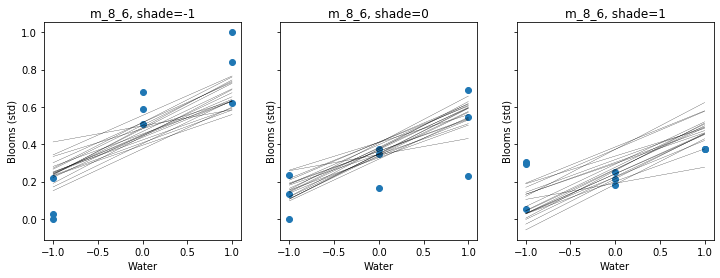

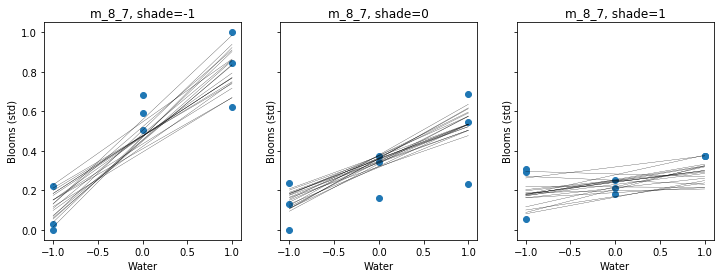

In [29]:
x=np.linspace(-1, 1, 1000)
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12,4))

shades=[-1,0,1]
for ax, s in zip(axs.flat, shades):
    idx = d.shade_cent[d.shade_cent==s].index
    ax.plot(d.water_cent[idx], d.blooms_std[idx], 'o')
    ax.set_xlabel('Water')
    ax.set_ylabel('Blooms (std)')
    ax.title.set_text(f'm_8_6, shade={s}')
    k=50
    while k<70:
        ax.plot(x, trace_8_6['a'][k] + trace_8_6['b_water'][k]*x 
                + trace_8_6['b_shade'][k]*s, linewidth=0.25, color='k')
        k+=1
        
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12,4))        
for ax, s in zip(axs.flat, shades):
    idx = d.shade_cent[d.shade_cent==s].index
    ax.plot(d.water_cent[idx], d.blooms_std[idx], 'o')
    ax.set_xlabel('Water')
    ax.set_ylabel('Blooms (std)')
    ax.title.set_text(f'm_8_7, shade={s}')
    k=50
    while k<70:
        ax.plot(x, trace_8_7['a'][k] + trace_8_7['b_water'][k]*x
                + trace_8_7['b_shade'][k]*s + trace_8_7['b_water_shade'][k]*s*x, linewidth=0.25, color='k')
        k+=1
 

In [30]:
# R code 8.26

# Unnecessary because I asked for the priors when I was making the models in the first place.
# Can you extract the priors from a trace/model without re-running the model? Might be good to know.

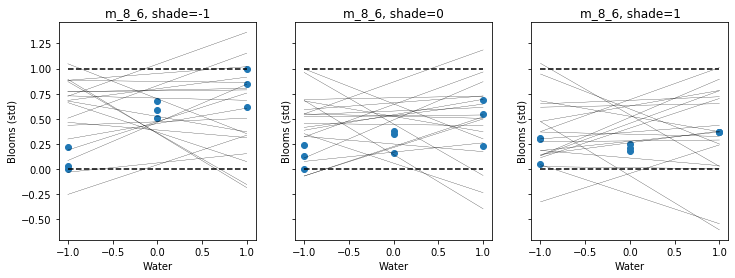

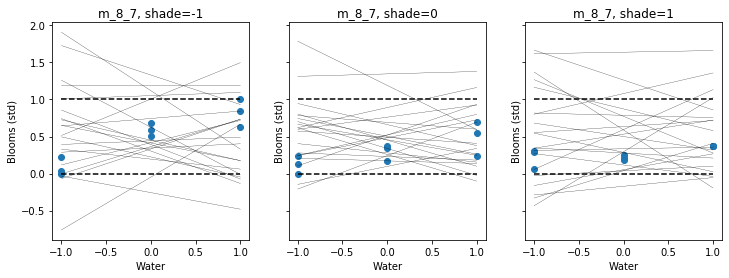

In [31]:
# Just taking a quick look at the priors:

x=np.linspace(-1, 1, 1000)
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12,4))

shades=[-1,0,1]
for ax, s in zip(axs.flat, shades):
    idx = d.shade_cent[d.shade_cent==s].index
    ax.plot(d.water_cent[idx], d.blooms_std[idx], 'o')
    ax.set_xlabel('Water')
    ax.set_ylabel('Blooms (std)')
    ax.title.set_text(f'm_8_6, shade={s}')
    ax.plot((-1,1), (1,1), 'k--')
    ax.plot((-1,1), (0,0), 'k--')
    k=50
    while k<70:
        ax.plot(x, prior_8_6['a'][k] + prior_8_6['b_water'][k]*x 
                + prior_8_6['b_shade'][k]*s, linewidth=0.25, color='k')
        k+=1
        
f, axs = plt.subplots(1, 3, sharey=True, figsize=(12,4))        
for ax, s in zip(axs.flat, shades):
    idx = d.shade_cent[d.shade_cent==s].index
    ax.plot(d.water_cent[idx], d.blooms_std[idx], 'o')
    ax.set_xlabel('Water')
    ax.set_ylabel('Blooms (std)')
    ax.title.set_text(f'm_8_7, shade={s}')
    ax.plot((-1,1), (1,1), 'k--')
    ax.plot((-1,1), (0,0), 'k--')
    k=50
    while k<70:
        ax.plot(x, prior_8_7['a'][k] + prior_8_7['b_water'][k]*x
                + prior_8_7['b_shade'][k]*s + prior_8_7['b_water_shade'][k]*s*x, linewidth=0.25, color='k')
        k+=1

# These priors are weakly realistic, but not harmful.

In [32]:
# 8E1
# (1) Temperature might affect the rate/amount of dough rise as well as the effectiveness of yeast
# (2) Socioeconomic status during childhood influences both income and education
# (3) I don't really know what "go" means here, but I guess an interaction effect might be the number of bullet holes
# in your car. Holes are likely to slow your car down and also influence the amount of gasoline in the car. I admit
# this is a stretch.

In [33]:
# 8E2
# (1) This is an interaction. The temperature will also affect the onions drying out.
# (2) I'm not a car guy. This IS an interaction if increasing the number of cylinders will make the car faster
# without requiring a better fuel injector. If that's not true, then this is not an interaction.
# (3) I do not think this is an interaction. The wording implies that beliefs come from either parents or friends, not
# some combination of both. Moreover I don't think friends depend on parents.
# (4) This seems like not an interaction, but I don't really know.

In [34]:
# 8E3

In [35]:
# 8M1
# When the temperature is too high, it doesn't matter how much water or shade the plant gets; it will not bloom.
# There must be some sort of biological link between temperature and bloom rate.

In [36]:
# 8M2
# mu = (T - T.max()) * (a + b_w * w + b_s * s + b_w_s * w * s)

In [37]:
# 8M3
# We want number of ravens to depend on number of wolves (food source) and also number of ravens (competition)
# Number of wolves should probably be independent of number of ravens but should depend on number of wolves
# My gut says we need an agent-based simulation where the number of ravens in each step depends on the previous step
# but let's try it the simpler way.

food = np.round(stats.norm.rvs(loc=50, scale=10, size = 10)) # 10 random amounts of food
wolves = np.floor(food/10) # assume each wolf requires 10 units of food
ravens = wolves**2 # I would expect each wolf to be able to support multiple ravens in some non-linear way

# This is way off, but I'm not really sure what the goal is.

In [6]:
bid = pd.Categorical(d['bed'])
d['bid']=bid.codes
d

,bed,water,shade,blooms,blooms_std,water_cent,shade_cent,bid
0,a,1,1,0.00,0.000000,-1.0,-1.0,0
1,a,1,2,0.00,0.000000,-1.0,0.0,0
2,a,1,3,111.04,0.307029,-1.0,1.0,0
3,a,2,1,183.47,0.507300,0.0,-1.0,0
4,a,2,2,59.16,0.163579,0.0,0.0,0
5,a,2,3,76.75,0.212216,0.0,1.0,0
6,a,3,1,224.97,0.622048,1.0,-1.0,0
7,a,3,2,83.77,0.231626,1.0,0.0,0
8,a,3,3,134.95,0.373141,1.0,1.0,0
9,b,1,1,80.10,0.221479,-1.0,-1.0,1


In [8]:
bid = pd.Categorical(d['bed'])
d['bid']=bid.codes

with pm.Model() as m_8_test:
    a = pm.Normal('a', mu=0.5, sd=0.25) 
    b_water = pm.Normal('b_water', mu=0, sd=0.25) 
    b_shade = pm.Normal('b_shade', mu=0, sd=0.25)
    b_water_shade = pm.Normal('b_water_shade', mu=0, sd=0.25)
    b_bid = pm.Normal('b_bid', mu=1, sd=0.5)
    mu = (a + b_water * (d.water_cent) + b_shade * d.shade_cent 
          + b_water_shade * d.water_cent * d.shade_cent + b_bid * d.bid)
    sigma = pm.Exponential('sigma', 1)
    blooms_std = pm.Normal('blooms_std', mu=mu, sd=sigma, observed=d.blooms_std)
    trace_8_test= pm.sample(5000, tune=1000, chains=1)
    #prior_8_8 = pm.sample_prior_predictive(samples=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [sigma, b_bid, b_water_shade, b_shade, b_water, a]
100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:09<00:00, 660.31it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [ ]:
bid = pd.Categorical(d['bed'])
d['bid']=bid.codes

with pm.Model() as m_8_8:
    a = pm.Normal('a', mu=0.5, sd=0.25, shape=len(bid.categories)) 
    b_water = pm.Normal('b_water', mu=0, sd=0.25, shape=len(bid.categories)) 
    b_shade = pm.Normal('b_shade', mu=0, sd=0.25, shape=len(bid.categories))
    b_water_shade = pm.Normal('b_water_shade', mu=0, sd=0.25, shape=len(bid.categories))
    mu = (a[bid] + b_water[bid] * (d.water_cent) + b_shade[bid] * d.shade_cent 
          + b_water_shade[bid] * d.water_cent * d.shade_cent)
    sigma = pm.Exponential('sigma', 1)
    blooms_std = pm.Normal('blooms_std', mu=mu, sd=sigma, observed=d.blooms_std)
    trace_8_8= pm.sample(5000, tune=1000, chains=1)
    #prior_8_8 = pm.sample_prior_predictive(samples=1000)

In [ ]:
mu = (a[bid] + b_water[bid] * (d.water_cent) + b_shade[bid] * d.shade_cent 
          + b_water_shade[bid] * d.water_cent * d.shade_cent)

In [ ]:
m_8_7.name = 'no bed'
m_8_8.name = 'beds'
comp_WAIC = pm.compare({m_8_3: trace_8_3, m_8_4: trace_8_4})
comp_WAIC